In [1]:
import tensorflow as tf
import numpy as np
from model import Model
import models.pixelcnn_cifar as pixelcnn
from utils import *
from defense import *

In [2]:
sess = tf.Session()

# Image and original class

Choose what you want here.

In [3]:
orig = np.load('ship.npy')
TRUE_CLASS = 8
EPSILON = 8.0
lower = np.clip(orig - EPSILON, 0, 255)
upper = np.clip(orig + EPSILON, 0, 255)

# Classifier and PixelCNN

In [4]:
model = Model(mode='eval')
saver = tf.train.Saver()
saver.restore(sess, tf.train.latest_checkpoint('data/models/naturally_trained'))

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
INFO:tensorflow:Restoring parameters from data/models/naturally_trained/checkpoint-70000


In [5]:
x = tf.placeholder(tf.float32, (1, 32, 32, 3))
_, out = pixelcnn.model(sess, x)

INFO:tensorflow:Restoring parameters from models/../data/params_cifar.ckpt


In [6]:
logits = model.pre_softmax
probs = tf.nn.softmax(logits)
classify = make_classify(sess, model.x_input, probs)

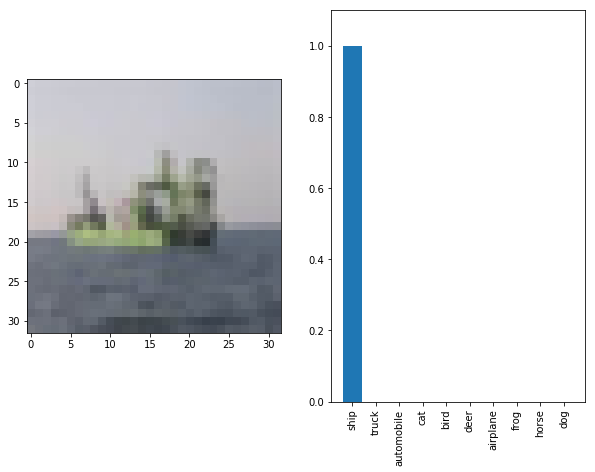

In [7]:
classify(orig)

# Failed attack (attempting to transfer)

In [8]:
grad, = tf.gradients(model.xent, model.x_input)

In [9]:
# PGD

LR = 0.5

adv = np.copy(orig)
for i in range(10):
    g, p = sess.run([grad, model.predictions], {model.x_input: [adv], model.y_input: [TRUE_CLASS]})
    print('step %d, pred=%d' % (i, p))
    # step
    adv += LR * np.sign(g[0])
    # project
    adv = np.clip(adv, lower, upper)

step 0, pred=8
step 1, pred=8
step 2, pred=9
step 3, pred=9
step 4, pred=9
step 5, pred=9
step 6, pred=9
step 7, pred=9
step 8, pred=9
step 9, pred=9


In [10]:
pixeldefend = make_pixeldefend(sess, x, out)

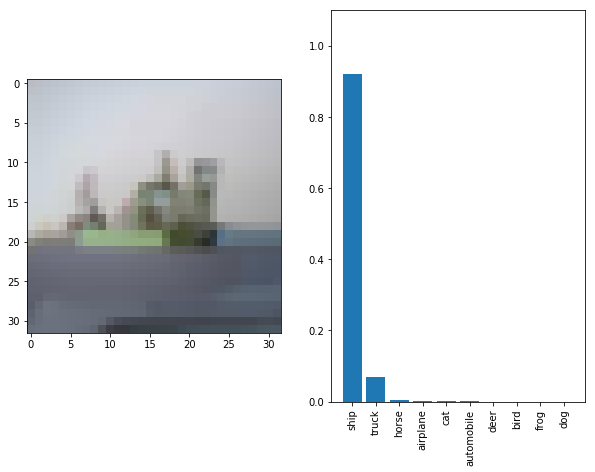

In [11]:
classify(pixeldefend(adv))

# Attack

Using BPDA.

In [12]:
# PGD

LR = 0.5

adv = np.copy(orig)
for i in range(20):
    adv_def = pixeldefend(adv)
    g, l, p = sess.run([grad, model.xent, model.predictions],
                       {model.x_input: [adv_def], model.y_input: [TRUE_CLASS]})
    print('step %d, loss=%g, pred=%d' % (i, l, p))
    if p != TRUE_CLASS:
        break
    # step
    adv += LR * np.sign(g[0])
    # project
    adv = np.clip(adv, lower, upper)

step 0, loss=0.00453313, pred=8
step 1, loss=0.0120309, pred=8
step 2, loss=0.689732, pred=8
step 3, loss=2.45019, pred=0


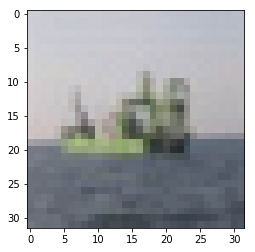

In [13]:
plt.imshow(adv/255.0)

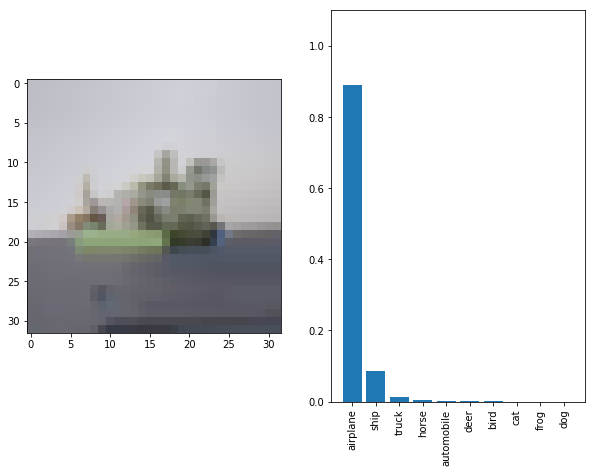

In [14]:
classify(pixeldefend(adv))